In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms

from sklearn.decomposition import PCA

from model_utils import load_model

### Load Data

In [3]:
# MNIST normalisation
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [4]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [5]:
# cos(theta) = (pc1_epoch1 · pc1_epoch2) / (||pc1_epoch1|| * ||pc1_epoch2||)
def cosine_angle_between_pcs(pc_a, pc_b):
    numerator = np.dot(pc_a, pc_b)
    denominator = np.linalg.norm(pc_a) * np.linalg.norm(pc_b)

    if denominator == 0:
        return np.nan

    cos_value = numerator / denominator
    if cos_value < -1.0 or cos_value > 1.0:
        cos_value = np.clip(cos_value, -1.0, 1.0)

    angle = np.arccos(cos_value) * 180 / np.pi

    if angle > 90:
        angle = 180 - angle
    
    return angle

In [6]:
size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32,]

### Measure angles between a PC over epochs
- For every model
    - For every epoch
        - Load model
        - Pass all test images through the model
        - PCA on all encodings
    - Calculate the angle between PC_i Epoch j and PC_i Epoch j+1
- Save the calculated angles

In [ ]:
model_type = 'sae'
all_angles = []

for model in range(10):
    latent_matrices = []
    for epoch in range(60):
        latent_matrix = []
        model_path = f"/home/david/mnist_model/{model_type}/{model}"
        ae = load_model(model_path, model_type=model_type, epoch=epoch)
        
        for image in test_images:
            image = torch.tensor(image, dtype=torch.float32).reshape(-1)

            with torch.no_grad():
                encoded, _ = ae(image)
                latent_matrix.append(encoded.detach().numpy())
        
        latent_matrix = np.stack(latent_matrix)

        pca = PCA(n_components=32)
        pca.fit(latent_matrix)

        pca_components = np.array(pca.components_)
        latent_matrices.append(pca_components)

    angles_per_model = []
    for i in range(32):
        angles_per_pc = []
        for j in range(59):
            cosine_angle = cosine_angle_between_pcs(latent_matrices[j][i], latent_matrices[j+1][i])
            angles_per_pc.append(cosine_angle)
        angles_per_model.append(angles_per_pc)
    all_angles.append(angles_per_model)

np.save(f"Saved_Results/{model_type}_pc_stability_all_angles.npy", all_angles)

In [ ]:
model_type = 'dae'
all_angles = []

for model in range(10):
    latent_matrices = []
    for epoch in range(60):
        latent_matrix = []
        model_path = f"/home/david/mnist_model/{model_type}/{model}"
        ae = load_model(model_path, model_type=model_type, epoch=epoch)
        
        for image in test_images:
            image = torch.tensor(image, dtype=torch.float32).reshape(-1)

            with torch.no_grad():
                encoded, _ = ae(image)
                latent_matrix.append(encoded.detach().numpy())
        
        latent_matrix = np.stack(latent_matrix)

        pca = PCA(n_components=size_ls[epoch])
        pca.fit(latent_matrix)

        pca_components = np.pad(pca.components_, (0, 32 - pca.components_.shape[0]), 'constant')
        latent_matrices.append(pca_components)

    angles_per_model = []
    for i in range(32):
        angles_per_pc = []
        for j in range(59):
            cosine_angle = cosine_angle_between_pcs(latent_matrices[j][i], latent_matrices[j+1][i])
            angles_per_pc.append(cosine_angle)
        angles_per_model.append(angles_per_pc)
    all_angles.append(angles_per_model)

np.save(f"Saved_Results/{model_type}_pc_stability_all_angles.npy", all_angles)

### Load the calculated angles, average them over all models and plot them

In [12]:
sae_angles = np.load("Saved_Results/sae_pc_stability_all_angles.npy")
average_all_angles = np.mean(all_angles, axis=0)
angle_matrix = np.array(average_all_angles)

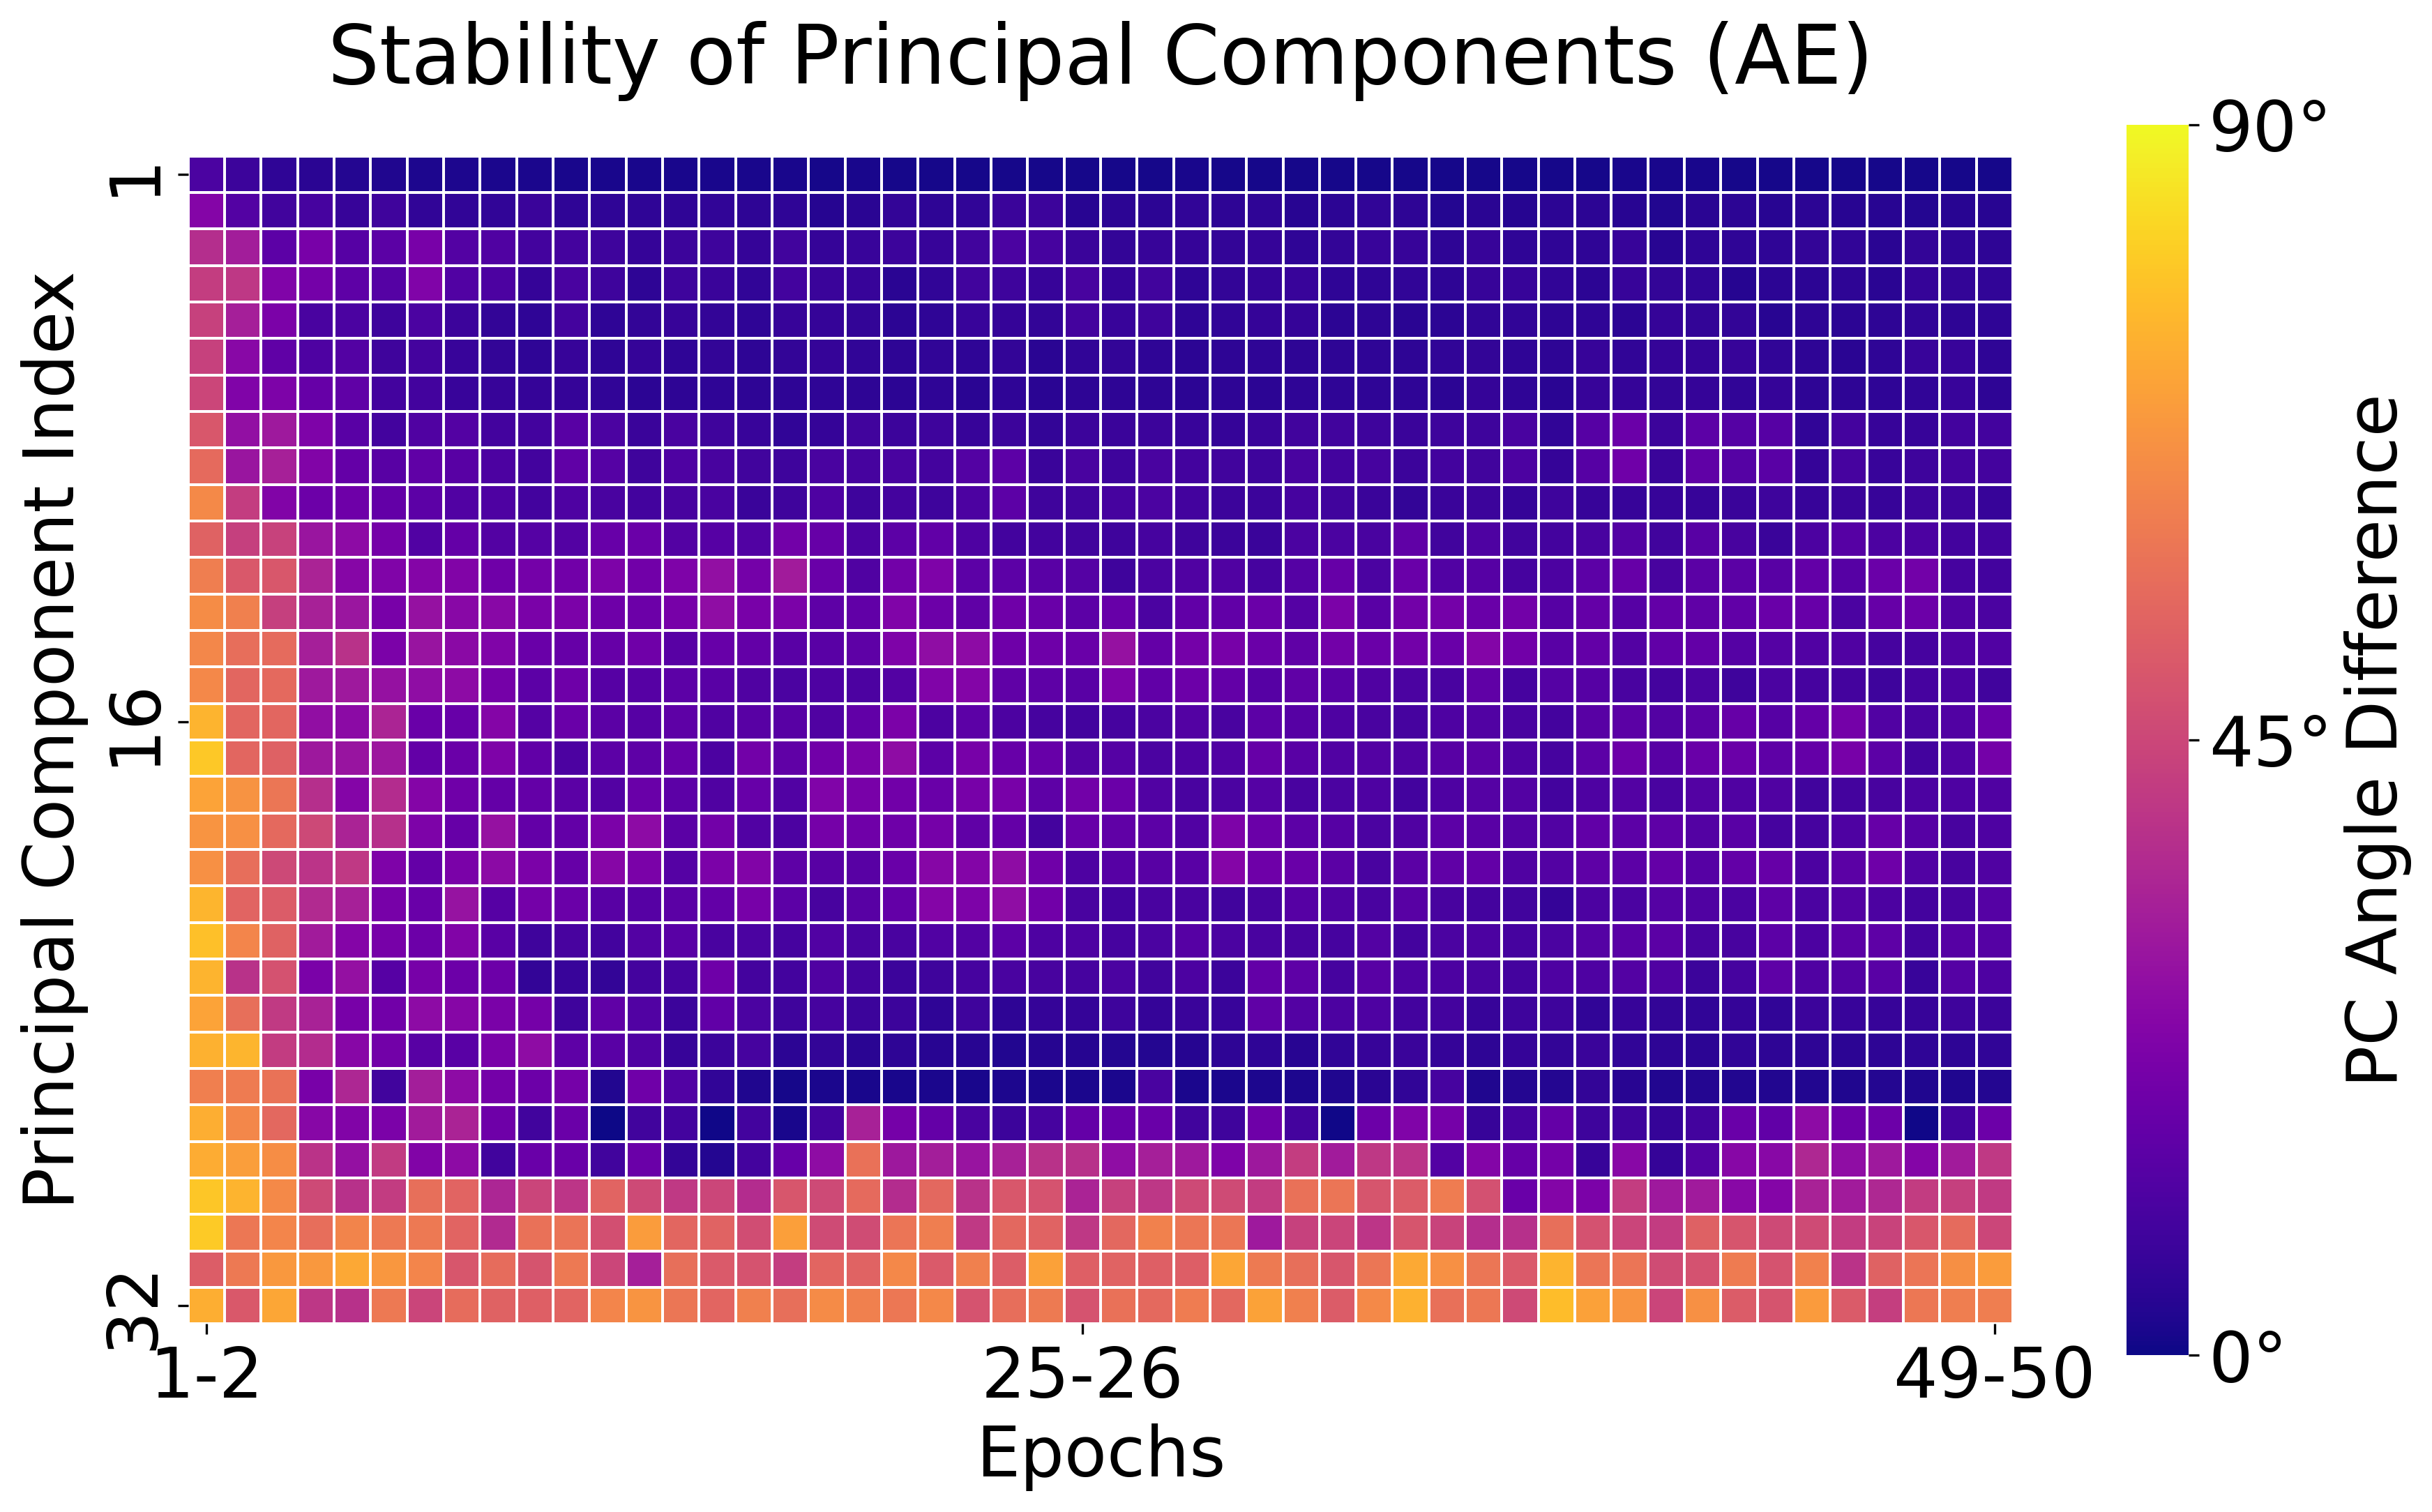

In [14]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    angle_matrix[:, :50],
    cmap="plasma",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
    square=True,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("PC Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["1", "16", "32"], fontsize=24, rotation=90)

ax.set_title("Stability of Principal Components (AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Principal Component Index", fontsize=24)

plt.savefig("Plots_png/sae_stability_of_pcs.png", bbox_inches="tight", dpi=300)
plt.savefig("Plots_svg/sae_stability_of_pcs.svg", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [16]:
dae_angles = np.load("Saved_Results/dae_pc_stability_all_angles.npy")
average_all_angles = np.mean(all_angles, axis=0)
angle_matrix = np.array(average_all_angles)
highlighted_non_computable_angles = angle_matrix.copy()

In [17]:
highlighted_non_computable_angles = np.load("Saved_Results/dae_pc_stability_all_angles.npy")[0]

for i in range(highlighted_non_computable_angles.shape[0]):
    for j in range(highlighted_non_computable_angles.shape[1] - 1):
        if np.isnan(highlighted_non_computable_angles[i, j]) and not np.isnan(highlighted_non_computable_angles[i, j + 1]):
            highlighted_non_computable_angles[i, j] = 100

mask = highlighted_non_computable_angles == 100
non_computable_cells = np.where(mask, 1, np.nan)

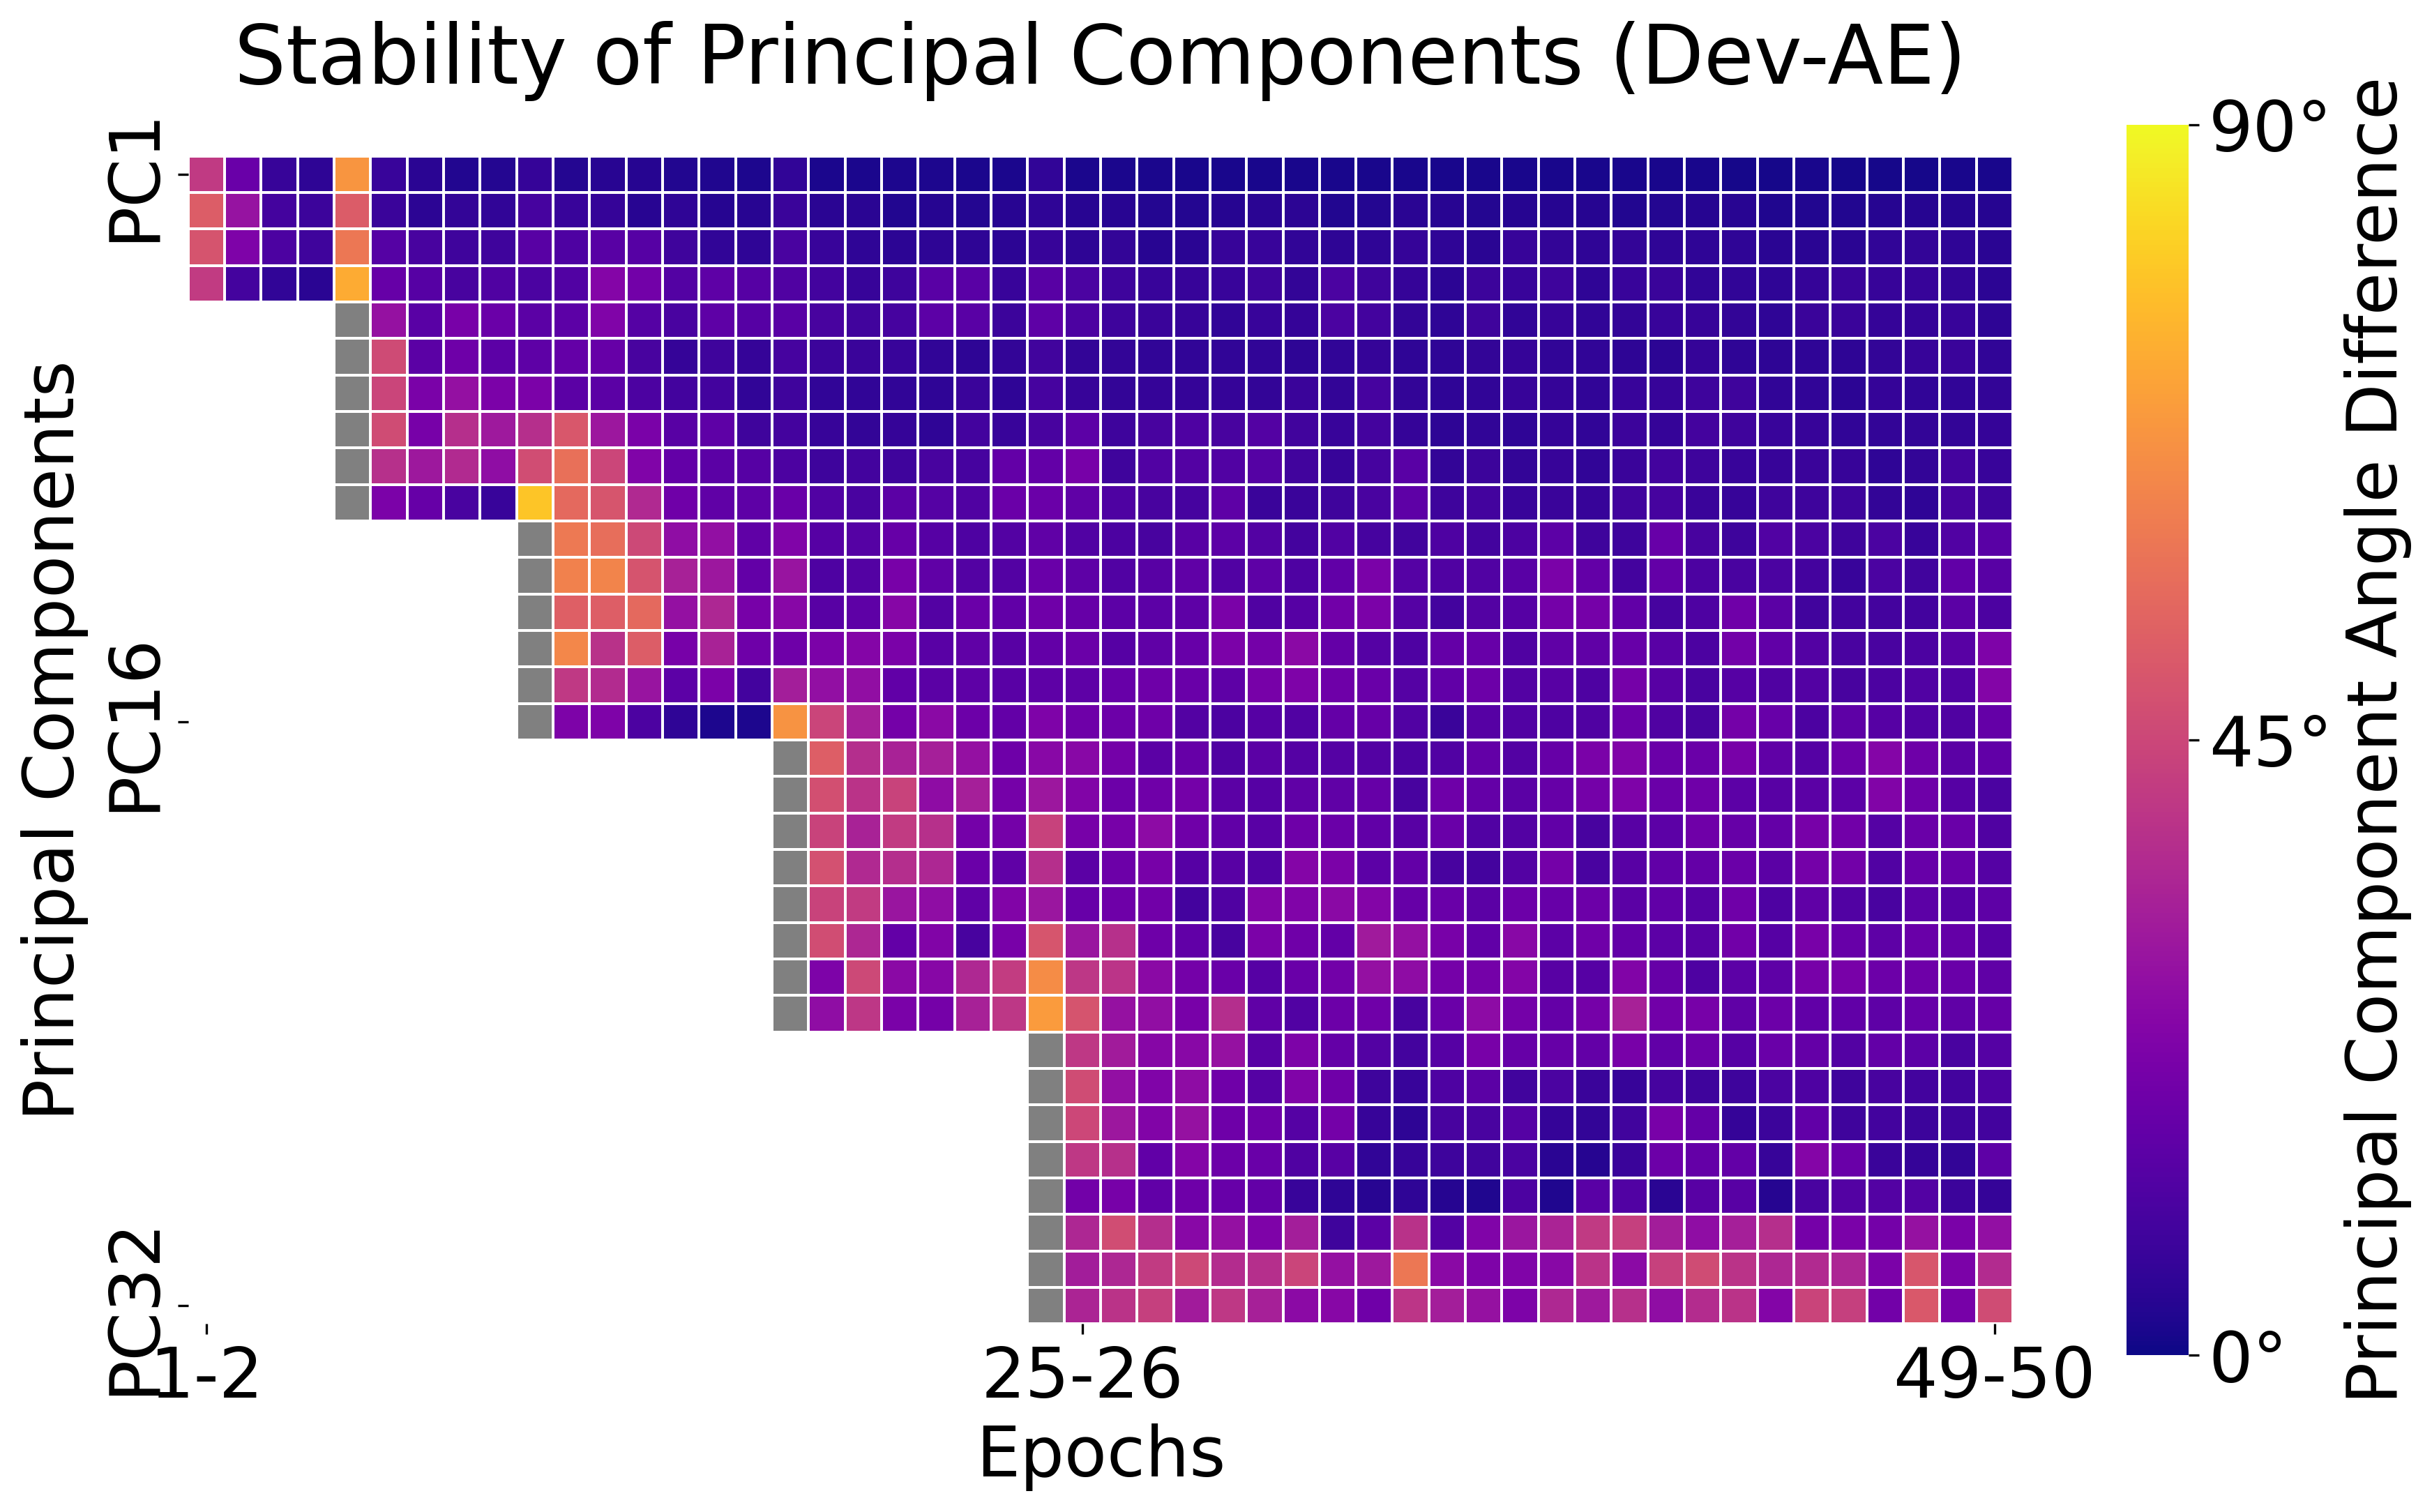

In [18]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

heatmap = sns.heatmap(
    angle_matrix,
    cmap="plasma",
    vmin=0,
    vmax=90,
    cbar_kws={"label": "Angle between PCs"},
    linewidths=0.5,
    square=True,
)

cmap_grey = ListedColormap(['grey'])
sns.heatmap(
    non_computable_cells[:, :50],
    cmap=cmap_grey,
    cbar=False,
    alpha=1,
    linewidths=0.5,
    square=True,
)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 45, 90])
cbar.set_ticklabels(["0°", "45°", "90°"], fontsize=24)
cbar.set_label("Principal Component Angle Difference", fontsize=24)
cbar.minorticks_off()

ax.set_xticks([0.5, 24.5, 49.5])
ax.set_xticklabels(["1-2", "25-26", "49-50"], fontsize=24, rotation=0)

ax.set_yticks([0.5, 15.5, 31.5])
ax.set_yticklabels(["PC1", "PC16", "PC32"], fontsize=24, rotation=90)

ax.set_title("Stability of Principal Components (Dev-AE)", fontsize=28, pad=25)
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Principal Components", fontsize=24)

plt.savefig("Plots_png/dae_stability_of_pcs.png", bbox_inches="tight", dpi=300)
plt.savefig("Plots_svg/dae_stability_of_pcs.svg", bbox_inches="tight")

plt.tight_layout()
plt.show()